#  DSC530-T304 Data Exploration and Analysis - Week 10 #

## Time Series Analysis ##

### Excercise Chapter 12 ###

-------

In [1]:
# Download pregency and respondent data files from thinkstat

from os.path import basename, exists

# Declare a function to download the files to local
def download(fileurl):
    filename = basename(fileurl)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(fileurl, filename)
        print("Downloaded " + local)

**Excercise 12**
--------


**Exercise 12-1**<br>
The linear model I used in this chapter has the obvious drawback that it is linear, and there is no reason to expect prices to change linearly over time. We can add flexibility to the model by adding a quadratic term, as we did in Section 11.3.
Use a quadratic model to fit the time series of daily prices, and use the model to generate predictions. You will have to write a version of RunLinearModel that runs that quadratic model, but after that you should be able to reuse code in timeseries.py to generate predictions.

In [2]:
# timeseries.py

# Dowload the python and data files to load pregnency and respondent data 
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/timeseries.py")

In [3]:
#http://zmjones.com/static/data/mj-clean.csv
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/mj-clean.csv")

In [4]:
import pandas as pd
# Load the cannabis data
weed_trans = pd.read_csv('mj-clean.csv', parse_dates=[5])

In [5]:
weed_trans.head()

,city,state,price,amount,quality,date,ppg,state.name,lat,lon
0,Annandale,VA,100,7.075,high,2010-09-02,14.13,Virginia,38.830345,-77.213870
1,Auburn,AL,60,28.300,high,2010-09-02,2.12,Alabama,32.578185,-85.472820
2,Austin,TX,60,28.300,medium,2010-09-02,2.12,Texas,30.326374,-97.771258
3,Belleville,IL,400,28.300,high,2010-09-02,14.13,Illinois,38.532311,-89.983521
4,Boone,NC,55,3.540,high,2010-09-02,15.54,North Carolina,36.217052,-81.687983


In [6]:
# Group the data by quality feature 
qlty_groups = weed_trans.groupby('quality')

In [7]:
# the group size shows most of the data consists of 'high' and 'medium' quality time and prices
qlty_groups.size()

quality
high      76411
low        6233
medium    64426
dtype: int64

In [8]:
# Build a function to group and aggregate the quality wise grouped data by date and derive a years  feature  
# by using min value of the date and derive year incremental value for subsequent data points.
import numpy as np
def GroupByTimeIncr(trans, func=np.mean):
    #print("********GroupByTimeIncr********")
    grpd_data = trans[['date', 'ppg']].groupby('date')
    daily = grpd_data.aggregate(func)
    daily['date'] = daily.index
    start = daily.date[0]
    one_year = np.timedelta64(1, 'Y')
    daily['years'] = (daily.date - start) / one_year
    return daily

In [9]:
# Create a dictionary to hold year increment time series data against each quality
daily_price = {}

In [10]:
# Assign the time sereis data against the quality name
for grp_nm, group_data in qlty_groups:
    daily_price[grp_nm] = GroupByTimeIncr(group_data)

In [11]:
daily_price

{'high':                   ppg       date     years
 date                                      
 2010-09-02  13.384186 2010-09-02  0.000000
 2010-09-03  14.459588 2010-09-03  0.002740
 2010-09-04  14.923333 2010-09-04  0.005479
 2010-09-05  16.667500 2010-09-05  0.008219
 2010-09-06  15.537500 2010-09-06  0.010959
 ...               ...        ...       ...
 2014-05-09  11.468298 2014-05-09  3.684932
 2014-05-10  10.532326 2014-05-10  3.687671
 2014-05-11  11.518750 2014-05-11  3.690411
 2014-05-12  10.578293 2014-05-12  3.693151
 2014-05-13   9.604615 2014-05-13  3.695890
 
 [1241 rows x 3 columns],
 'low':                   ppg       date     years
 date                                      
 2010-09-02   4.943750 2010-09-02  0.000000
 2010-09-03   3.984138 2010-09-03  0.002740
 2010-09-04   3.530000 2010-09-04  0.005479
 2010-09-10   4.240000 2010-09-10  0.021918
 2010-09-14   6.066118 2010-09-14  0.032877
 ...               ...        ...       ...
 2014-05-09  14.700000 2014-05-09

In [12]:
import statsmodels.formula.api as smf

# Build a linerar regression model using the years incremental value vs the cannibis price
def RunLinearModel(daily_mean_price):
    #print("*********RunLinearModel*********")
    model_data  = smf.ols("ppg ~ years", data=daily_mean_price)
    modl_res = model_data.fit()
    return model_data, modl_res

# Build a linerar regression model using the years  and years quardratic incremental value vs the cannibis price
def RunLinearModelWithQuadYear(daily_mean_price):
    #print("*********RunLinearModelWithQuadYear*********")
    daily_mean_price["years2"] = daily_mean_price.years**2
    model_data  = smf.ols("ppg ~ years + years2", data=daily_mean_price)
    modl_res = model_data.fit()
    return model_data, modl_res

In [13]:
# Run the model for years  and years quardratic incremental value vs the cannibis price  and print the model summary
for grp_nm, group_data in  daily_price.items():
    model_data, modl_res = RunLinearModelWithQuadYear(group_data)
    print('\n\nSummary for ', grp_nm )
    print(modl_res.summary())



Summary for  high
                            OLS Regression Results                            
Dep. Variable:                    ppg   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     517.5
Date:                Sun, 18 Feb 2024   Prob (F-statistic):          4.57e-164
Time:                        11:33:52   Log-Likelihood:                -1497.4
No. Observations:                1241   AIC:                             3001.
Df Residuals:                    1238   BIC:                             3016.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.6980      0.067

<table align="left">

|Quality | R-Squared | Adjusted R square | skew |	Kurtosis |
| :- |:-: |:-: |:-: |-: |
|high| 0.455 | 0.454 |	0.199 |	4.43 |
|medium|0.085|0.083|0.585|7.517|
|low|0.037|0.036|2.415|13.651|
||||||

                                                 Intercept
|Quality|Co-eff|std error|t|P -value|
| :- |:-: |:-: |:-: |:-: |
|high|13.698|0.067|205.757|0|
|medium|8.3509|0.104|80.512|0|
|low|4.705|0.287|16.393|0|
||||||

                                                years
|Quality|Co-eff|std error|t|P -value|
| :-: |:-: |:-: |:-: |:-: |
|high|-1.1164|0.084|-13.326|0|
|medium|1.1464|0.13|8.806|0|
|low|1.6318|0.357|4.573|0|
||||||

                                              Quadratic year
|Quality|Co-eff|std error|t|P -value|
| :-: |:-: |:-: |:-: |:-: |
|high|0.1131|0.022|5.06|0|
|medium|-0.2383|0.035|-6.878|0|
|low|-0.2933|0.095|-3.091|0.002|
    
    
    

   

------
### Skew  <br>

 - The high,  medium and low distributions are skewed to the right indicating longer right tail
 - low has a high kurtosis,  meaning sharp peak than normal distribution and  high skew indicating very long right tail
    
**Overall**<br> 
 - 
 ***Co-relation***<br>
 - Absolute price of cannibis  is influenced heavily for every year by  13.6 times for 'high' quality compared to 8.4 times for 'medium' quality and 4.7 times quality<br>
  ***Standard error*** 
 - It is less for 'high' quality compared to 'medium and 'low' quality<br>
***P-value*** 
 - Shows a ideal co-relation which needs to be investiagted<br>
    
    
**Years**<br> 
 - 
 ***Co-relation***<br>
 - Absolute price of cannibis  is negatively  influenced by equal propotion by year value  for every year for 'high' quality compared to postive impact  for 'medium' and 'low' quality<br>
  ***Standard error*** 
 - Follows simillar pattern as overall data points where 'high' has less compared to 'medium' and which is lesser than 'low'<br>
***P-value*** 
 - Shows a ideal co-relation which needs to be investiagted<br>
 
 
 **Years2**<br> 
 - 
 ***Co-relation***<br>
 - Absolute price of cannibis  is   influenced lesser for every year by quadratic year value  for  'high' quality compared to lesser negative  impact  for 'medium' and 'low' quality<br>
  ***Standard error*** 
 - Follows simillar pattern as overall data points where 'high' has less compared to 'medium' and which is lesser than 'low'<br>
***P-value*** 
 - Shows a ideal co-relation  for 'high' , 'medium' which needs to be investiagted,  'low' also has less p-value<br>
 

    

In [14]:
import timeseries as ts
import thinkplot
import thinkstats2

In [15]:
# run the model and capture the results
model_data, modl_res = RunLinearModelWithQuadYear(daily_price['high'])

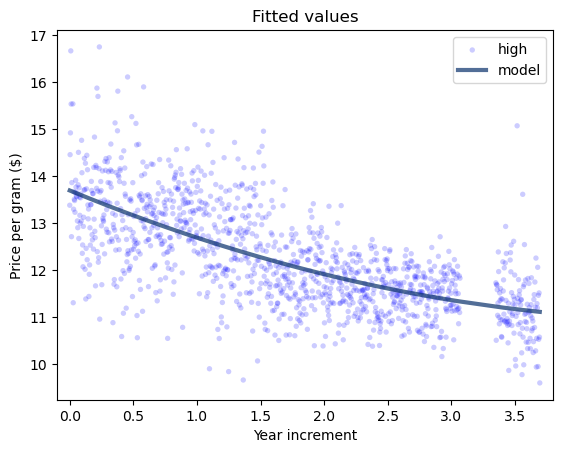

In [16]:
# plot the overall trend for 
ts.PlotFittedValues(model_data, modl_res, label='high')
thinkplot.Config(
    title="Fitted values", xlabel="Year increment", xlim=[-0.1, 3.8], ylabel="Price per gram ($)"
)

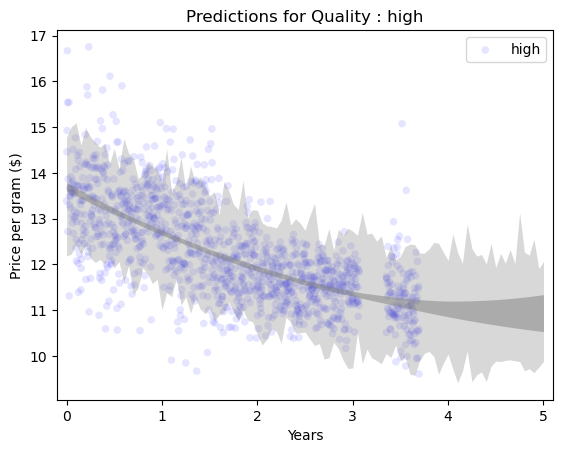

In [17]:
years = np.linspace(0, 5, 101)
thinkplot.Scatter(daily_price['high'].years, daily_price['high'].ppg, alpha=0.1, label='high')
ts.PlotPredictions(daily_price['high'], years, func=RunLinearModelWithQuadYear)
thinkplot.Config(
    title="Predictions for Quality : high",
    xlabel="Years",
    xlim=[years[0] - 0.1, years[-1] + 0.1],
    ylabel="Price per gram ($)",
)

- **Predicted prices going down with the time. It is less not impacted by model errors as the slope is almost close the actual values.  Missing data might be the reason for the wider confidence interval. Sampling erros due to estimated  parameters might have had a an impact on the variations and high outliers having an impact.    random variation in the observed data also might hae had ana impact.**

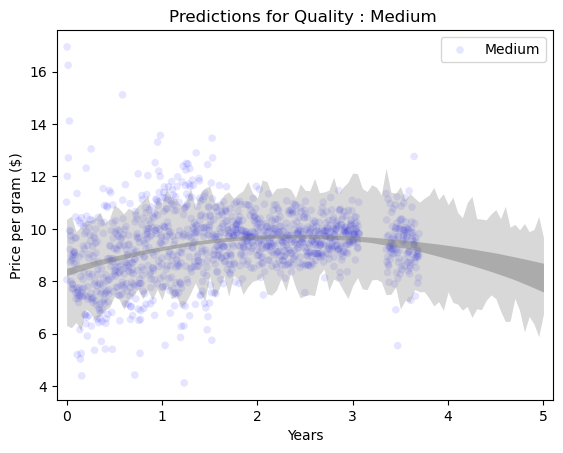

In [18]:
years = np.linspace(0, 5, 101)
thinkplot.Scatter(daily_price['medium'].years, daily_price['medium'].ppg, alpha=0.1, label='Medium')
ts.PlotPredictions(daily_price['medium'], years, func=RunLinearModelWithQuadYear)
thinkplot.Config(
    title="Predictions for Quality : Medium ",
    xlabel="Years",
    xlim=[years[0] - 0.1, years[-1] + 0.1],
    ylabel="Price per gram ($)",
)

- **Predicted prices vary or converge and takes a turn with slope chaning in betweeen might have been due to Modelling erros.  Missing data might have changed the slope to flat line after year 3.  Sampling erros seem to be less as the variations are reducting or maintaining simiallar range. Random variation in the observed data also might have changed the slope of the regression line**

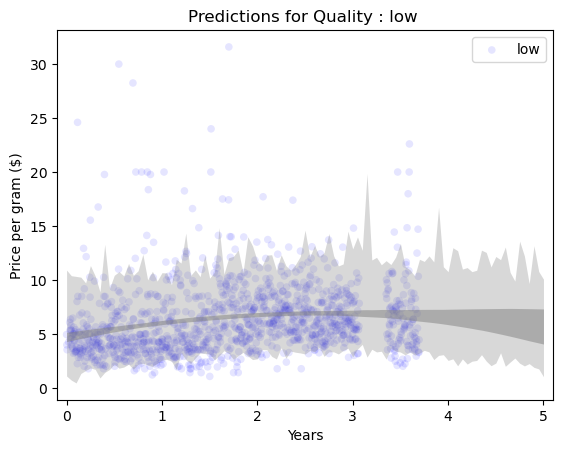

In [19]:
years = np.linspace(0, 5, 101)
thinkplot.Scatter(daily_price['low'].years, daily_price['low'].ppg, alpha=0.1, label='low')
ts.PlotPredictions(daily_price['low'], years, func=RunLinearModelWithQuadYear)
thinkplot.Config(
    title="Predictions for Quality : low ",
    xlabel="Years",
    xlim=[years[0] - 0.1, years[-1] + 0.1],
    ylabel="Price per gram ($)",
)

- **Predicted prices maintain a flat line with more or less the same slope indicating the modeling worked bettwe on predictions. Sampling error might have had a impact due to high outliers and for a huge variance and confidence interval,  Even the total population is very less compared to 'high'  and 'medium'  quality. Random variation due to esitmated parameters for future is rabge bound and varies drastically


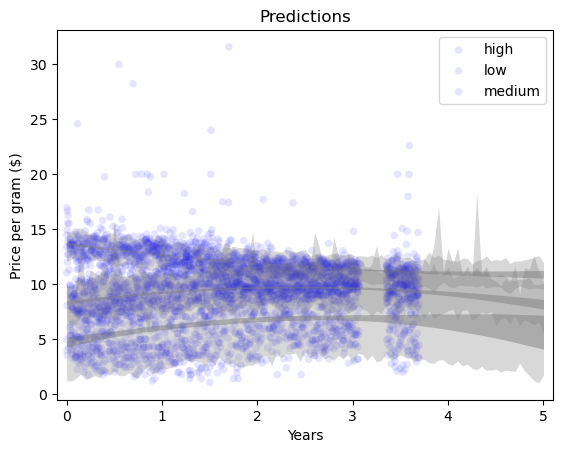

In [20]:
years = np.linspace(0, 5, 101)
for grp_nm, group_data in  daily_price.items():
    thinkplot.Scatter(group_data.years, group_data.ppg, alpha=0.1, label=grp_nm)
    ts.PlotPredictions(group_data, years, func=RunLinearModelWithQuadYear)
    thinkplot.Config(
        title="Predictions",
        xlabel="Years",
        xlim=[years[0] - 0.1, years[-1] + 0.1],
        ylabel="Price per gram ($)",
    )

**The model shows predicted prices overall decreases over time. Only low quality is expected with in the same price ranges.  Also the price gap betweeen quality reduces over time.**


----

**Excercsie 12-2**

Write a definition for a class named SerialCorrelationTest that extends HypothesisTest from Section 9.2. It should take a series and a lag as data, compute the serial correlation of the series with the given lag, and then compute the p-value of the observed correlation.
Use this class to test whether the serial correlation in raw price data is statistically significant. Also test the residuals of the linear model and (if you did the previous exercise), the quadratic model.

In [21]:
#Write a definition for a class named SerialCorrelationTest that extends HypothesisTest from Section 9.2
class SerialCorrelationTest(thinkstats2.HypothesisTest):
    
    #serial cor-relation takes a series and a log value 
    def TestStatistic(self, data):
        #self.data = data
        price_series, timelag = data
        test_stat = abs(thinkstats2.SerialCorr(price_series, timelag))
        #print(test_stat)
        return test_stat
    
    def RunModel(self):
        series, lag = self.data
        permutation = series.reindex(np.random.permutation(series.index))
        return permutation, lag
        

In [22]:
# test the correlation using the thinkstat2 libraries
name = "high"
daily = daily_price[name]

series = daily.ppg
cov_value = SerialCorrelationTest((series, 1))
pvalue = cov_value.PValue()
print(cov_value.actual, pvalue)



0.4852293761947381 0.0


In [23]:
# Test the co-relation using dataframe correlation
xs = series
ys = series.shift(1)
correlation = xs.corr(ys)
print(correlation)

0.4852293761947381


In [24]:
# Run a serial correlation test using the lag value of the same years time series data
for grp_nm, group_data in  daily_price.items():
    series = group_data.ppg
    cov_value = SerialCorrelationTest((series, 1))
    pvalue = cov_value.PValue()
    print("for the Quality ", grp_nm , "  : Correlation of price with lag  and P-value of Observed shuffled prices" )
    print("\t\t\t\t\t", cov_value.actual, "\t\t", pvalue, "\n")

for the Quality  high   : Correlation of price with lag  and P-value of Observed shuffled prices
					 0.4852293761947381 		 0.0 

for the Quality  low   : Correlation of price with lag  and P-value of Observed shuffled prices
					 0.11657497441101058 		 0.0 

for the Quality  medium   : Correlation of price with lag  and P-value of Observed shuffled prices
					 0.16006429989181092 		 0.0 



The co-relation between price sequence for **high quality** is close to 50%  indicates that does not rule out the null hypothesis on that there is no statiscally signifance on correlation,  When the sequnce values are shuffled  and tested with lag,  the serial correlation has lesser values than actual for all 1000 iterations  <br><br>
The co-relation between price sequence for **low quality** is at 12%  indicates that it has less chances to prove against the null hypothesis that no presence of  statiscally signifance on correlation,  When the sequnce values are shuffled  and tested with lag,  the serial correlation has lesser values than actual for all  1000 iterations<br><br>
The co-relation between price sequence for **medium quality**  is 16%  indicates that it has less chances to prove against the null hypothesis that no presence of  statiscally signifance on correlation,  When the sequnce values are shuffled  and tested with lag,  the serial correlation has lesser values than actual for all  1000 iterations<br><br>

In [25]:
# Run the linear regression and get the co-relations for residuals for years
print("*** Generating residuals Correlation for years vs price residuals ***\n")
for grp_nm, group_data in  daily_price.items():   
    model_data, model_results = RunLinearModel(group_data)
    res_series = model_results.resid
    cov_value = SerialCorrelationTest((res_series, 1))
    pvalue = cov_value.PValue()

    print("for the Quality ", grp_nm , "  : Correlation of residuals with lag  and P-value of Observed shuffled residuals" )
    print("\t\t\t\t\t", cov_value.actual, "\t\t", pvalue, "\n")

*** Generating residuals Correlation for years vs price residuals ***

for the Quality  high   : Correlation of residuals with lag  and P-value of Observed shuffled residuals
					 0.07570473767506264 		 0.009 

for the Quality  low   : Correlation of residuals with lag  and P-value of Observed shuffled residuals
					 0.08950837134781882 		 0.001 

for the Quality  medium   : Correlation of residuals with lag  and P-value of Observed shuffled residuals
					 0.11560586074036004 		 0.0 



The co-relation between price residuals sequence for **high quality** is at 8%  indicates that does not rule out the null hypothesis on that there is no statiscally signifance on correlation,  When the sequnce values are shuffled  and tested with lag,  around 7  serial correlation has higher value out of 1000 shuffles than actual correlation  <br><br>
The co-relation between price residuals sequence for **low quality** is at 12%  indicates that it has less chances to prove against the null hypothesis that no presence of  statiscally signifance on correlation,  When the sequnce values are shuffled  and tested with lag,  around 1  serial correlation has higher value out of 1000 shuffles than actual correlation<br><br>
The co-relation between price residuals sequence for **medium quality**  is 16%  indicates that it has less chances to prove against the null hypothesis that no presence of  statiscally signifance on correlation,  When the sequnce values are shuffled  and tested with lag,  the serial correlation has lesser values than actual for all the 1000 iterations<br><br>

In [26]:
# Run the linear regression  and get the co-relations residuals for residuals for years,  resilduals of quadratic years   
print("*** Generating residuals Correlation for years and square of years vs price residuals ***\n")
for grp_nm, group_data in  daily_price.items():   
    model_data, model_results = RunLinearModelWithQuadYear(group_data)
    res_series = model_results.resid
    cov_value = SerialCorrelationTest((res_series, 1))
    pvalue = cov_value.PValue()

    print("for the Quality ", grp_nm , "  : Correlation of residuals with lag  and P-value of Observed shuffled residuals" )
    print("\t\t\t\t\t", cov_value.actual, "\t\t", pvalue, "\n")

*** Generating residuals Correlation for years and square of years vs price residuals ***

for the Quality  high   : Correlation of residuals with lag  and P-value of Observed shuffled residuals
					 0.05607308161289923 		 0.048 

for the Quality  low   : Correlation of residuals with lag  and P-value of Observed shuffled residuals
					 0.0822265937058341 		 0.007 

for the Quality  medium   : Correlation of residuals with lag  and P-value of Observed shuffled residuals
					 0.08089524938917436 		 0.007 



The co-relation between price residuals sequence for **high quality** is close to 50%  that does not rule out the null hypothesis on that there is no statiscally signifance on correlation,  When the sequnce values are shuffled  and tested with lag,  around 51  shuffled serial correlation has higher value out of 1000 shuffles than actual correlation  <br><br>
The co-relation between price residuals sequence for **low quality** is at 12%  that it has less chances to prove against the null hypothesis that no presence of  statiscally signifance on correlation,  When the sequnce values are shuffled  and tested with lag,  7  serial shuffled correlation has higher value out of 1000 shuffles than actual correlation<br><br>
The co-relation between price residuals sequence for **medium quality**  is 16%  that it has less chances to prove against the null hypothesis that no presence of  statiscally signifance on correlation,  When the sequnce values are shuffled  and tested with lag,   5  serial shuffled correlation has higher value out of 1000 shuffles than actual correlation<br><br>